In [2]:
!pip install yfinance==0.2.65

In [3]:
!pip install finta

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime 
from math import sqrt
import seaborn as sns
from finta import TA
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split,KFold,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,r2_score
import streamlit as st
import warnings
warnings.filterwarnings('ignore')

In [5]:
import yfinance as yf

## Data Collection

In [6]:
yf.enable_debug_mode()

In [7]:
Coca_Cola=yf.Ticker("KO")

In [9]:
Coca_Cola_info=Coca_Cola.info

DEBUG    get_raw_json(): https://query2.finance.yahoo.com/v10/finance/quoteSummary/KO
DEBUG    Entering get()
DEBUG     Entering _make_request()
DEBUG      url=https://query2.finance.yahoo.com/v10/finance/quoteSummary/KO
DEBUG      params={'modules': 'financialData,quoteType,defaultKeyStatistics,assetProfile,summaryDetail', 'corsDomain': 'finance.yahoo.com', 'formatted': 'false', 'symbol': 'KO'}
DEBUG      Entering _get_cookie_and_crumb()
DEBUG       cookie_mode = 'basic'
DEBUG       Entering _get_cookie_and_crumb_basic()
DEBUG        Entering _get_cookie_basic()
DEBUG         Entering _load_cookie_curlCffi()
DEBUG         Exiting _load_cookie_curlCffi()
DEBUG         reusing persistent cookie
DEBUG        Exiting _get_cookie_basic()
DEBUG        Entering _get_crumb_basic()
DEBUG         Entering _get_cookie_basic()
DEBUG          reusing cookie
DEBUG         Exiting _get_cookie_basic()
DEBUG         crumb = 'hKwAwGpNtnJ'
DEBUG        Exiting _get_crumb_basic()
DEBUG       Exiting _get

In [10]:
Coca_Cola_info

{'address1': 'One Coca-Cola Plaza',
 'city': 'Atlanta',
 'state': 'GA',
 'zip': '30313',
 'country': 'United States',
 'phone': '404 676 2121',
 'website': 'https://www.coca-colacompany.com',
 'industry': 'Beverages - Non-Alcoholic',
 'industryKey': 'beverages-non-alcoholic',
 'industryDisp': 'Beverages - Non - Alcoholic',
 'sector': 'Consumer Defensive',
 'sectorKey': 'consumer-defensive',
 'sectorDisp': 'Consumer Defensive',
 'longBusinessSummary': 'The Coca-Cola Company, a beverage company, manufactures and sells various nonalcoholic beverages in the United States and internationally. The company provides sparkling soft drinks and flavors; water, sports, coffee, and tea; juice, value-added dairy, and plant-based beverages; and other beverages. It also offers beverage concentrates and syrups, as well as fountain syrups to fountain retailers comprising restaurants and convenience stores. The company sells its products under the Coca-Cola, Diet Coke/Coca-Cola Light, Coca-Cola Zero Suga

In [11]:
info_df=pd.json_normalize(Coca_Cola_info)
info_df

,address1,city,state,zip,country,phone,website,industry,industryKey,industryDisp,...,fiftyDayAverageChange,fiftyDayAverageChangePercent,twoHundredDayAverageChange,twoHundredDayAverageChangePercent,sourceInterval,exchangeDataDelayedBy,averageAnalystRating,cryptoTradeable,displayName,trailingPegRatio
0,One Coca-Cola Plaza,Atlanta,GA,30313,United States,404 676 2121,https://www.coca-colacompany.com,Beverages - Non-Alcoholic,beverages-non-alcoholic,Beverages - Non - Alcoholic,...,-1.198601,-0.016982,1.494698,0.022018,15,0,1.5 - Buy,False,Coca-Cola,2.6247


##  Load the dataset into a dataframe

In [12]:
KO_df=Coca_Cola.history(period="max")
KO_df.head()

DEBUG    Entering history()
DEBUG     Entering history()
DEBUG      KO: Yahoo GET parameters: {'period1': '1926-08-24 06:51:47-04:00', 'period2': '2025-07-30 06:51:42-04:00', 'interval': '1d', 'includePrePost': False, 'events': 'div,splits,capitalGains'}
DEBUG      Entering get()
DEBUG       Entering _make_request()
DEBUG        url=https://query2.finance.yahoo.com/v8/finance/chart/KO
DEBUG        params={'period1': -1368191293, 'period2': 1753872702, 'interval': '1d', 'includePrePost': False, 'events': 'div,splits,capitalGains'}
DEBUG        Entering _get_cookie_and_crumb()
DEBUG         cookie_mode = 'basic'
DEBUG         Entering _get_cookie_and_crumb_basic()
DEBUG          Entering _get_cookie_basic()
DEBUG           reusing cookie
DEBUG          Exiting _get_cookie_basic()
DEBUG          Entering _get_crumb_basic()
DEBUG           reusing crumb
DEBUG          Exiting _get_crumb_basic()
DEBUG         Exiting _get_cookie_and_crumb_basic()
DEBUG        Exiting _get_cookie_and_crumb()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1962-01-02 00:00:00-05:00,0.045716,0.046961,0.045716,0.045716,806400,0.0,0.0
1962-01-03 00:00:00-05:00,0.045038,0.045038,0.044019,0.044698,1574400,0.0,0.0
1962-01-04 00:00:00-05:00,0.044811,0.045377,0.044811,0.045037,844800,0.0,0.0
1962-01-05 00:00:00-05:00,0.045037,0.045603,0.043906,0.044019,1420800,0.0,0.0
1962-01-08 00:00:00-05:00,0.043679,0.043679,0.042718,0.043566,2035200,0.0,0.0


In [13]:
KO_df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-07-23 00:00:00-04:00,69.660004,69.739998,68.599998,69.160004,21030000,0.0,0.0
2025-07-24 00:00:00-04:00,69.260002,69.550003,68.989998,69.099998,12511400,0.0,0.0
2025-07-25 00:00:00-04:00,69.129997,69.230003,68.750000,69.169998,12574800,0.0,0.0
2025-07-28 00:00:00-04:00,68.739998,68.900002,68.059998,68.089996,13668800,0.0,0.0
2025-07-29 00:00:00-04:00,68.339996,69.419998,68.150002,69.379997,16215500,0.0,0.0


In [14]:
KO_df1=KO_df.copy()

In [15]:
KO_df.reset_index(inplace=True)
KO_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1962-01-02 00:00:00-05:00,0.045716,0.046961,0.045716,0.045716,806400,0.0,0.0
1,1962-01-03 00:00:00-05:00,0.045038,0.045038,0.044019,0.044698,1574400,0.0,0.0
2,1962-01-04 00:00:00-05:00,0.044811,0.045377,0.044811,0.045037,844800,0.0,0.0
3,1962-01-05 00:00:00-05:00,0.045037,0.045603,0.043906,0.044019,1420800,0.0,0.0
4,1962-01-08 00:00:00-05:00,0.043679,0.043679,0.042718,0.043566,2035200,0.0,0.0


In [16]:
KO_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype                           
---  ------        --------------  -----                           
 0   Date          16000 non-null  datetime64[ns, America/New_York]
 1   Open          16000 non-null  float64                         
 2   High          16000 non-null  float64                         
 3   Low           16000 non-null  float64                         
 4   Close         16000 non-null  float64                         
 5   Volume        16000 non-null  int64                           
 6   Dividends     16000 non-null  float64                         
 7   Stock Splits  16000 non-null  float64                         
dtypes: datetime64[ns, America/New_York](1), float64(6), int64(1)
memory usage: 1000.1 KB


In [17]:
KO_df.isnull().sum()

Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

## Data Analysis and Visualisation

### The trend of stock whether bullish or bearish

In [18]:
Q1_close=KO_df['Close'].quantile(0.25)
Q3_close=KO_df['Close'].quantile(0.75)
IQR_close=Q3_close-Q1_close
max_close=Q3_close + (1.5 * IQR_close)
close_df=KO_df[KO_df['Close']>max_close]
close_df



,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
14487,2019-07-23 00:00:00-04:00,44.293762,45.449974,43.886175,45.192116,33417900,0.0,0.0
14488,2019-07-24 00:00:00-04:00,45.017434,45.599700,44.601530,44.734619,15633400,0.0,0.0
14489,2019-07-25 00:00:00-04:00,44.609845,44.751251,43.852900,44.144032,19135000,0.0,0.0
14490,2019-07-26 00:00:00-04:00,44.368611,45.175465,44.243839,45.059010,11451900,0.0,0.0
14491,2019-07-29 00:00:00-04:00,45.059013,45.167149,44.834428,44.909290,12283900,0.0,0.0
...,...,...,...,...,...,...,...,...
15995,2025-07-23 00:00:00-04:00,69.660004,69.739998,68.599998,69.160004,21030000,0.0,0.0
15996,2025-07-24 00:00:00-04:00,69.260002,69.550003,68.989998,69.099998,12511400,0.0,0.0
15997,2025-07-25 00:00:00-04:00,69.129997,69.230003,68.750000,69.169998,12574800,0.0,0.0
15998,2025-07-28 00:00:00-04:00,68.739998,68.900002,68.059998,68.089996,13668800,0.0,0.0


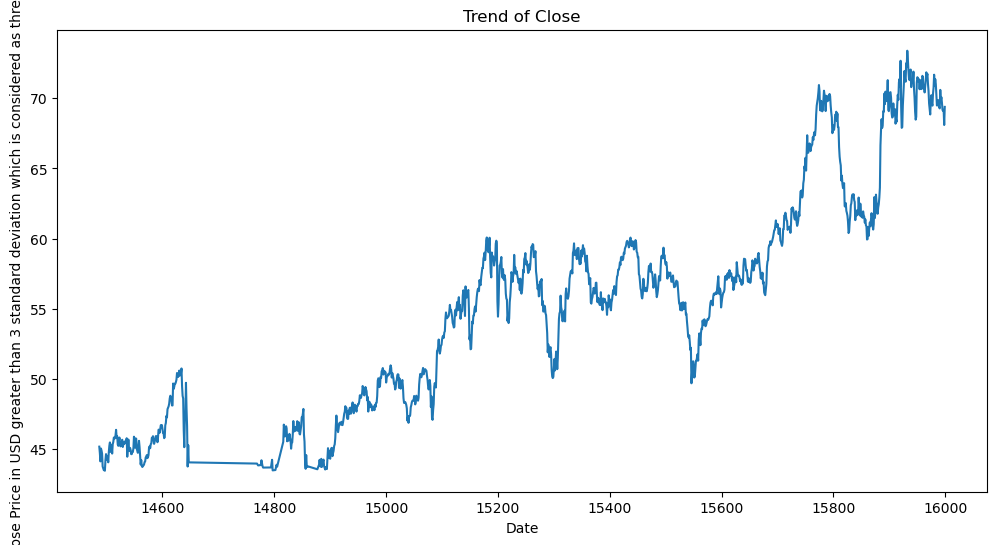

In [19]:
plt.figure(figsize=(12,6))
plt.plot(close_df['Close'])
plt.title('Trend of Close')
plt.xlabel('Date')
plt.ylabel('Close Price in USD greater than 3 standard deviation which is considered as threshold')
plt.show()

The stock shows a bullish trend from 2019-07-03 onwards. 

### Coca Cola stock attributes

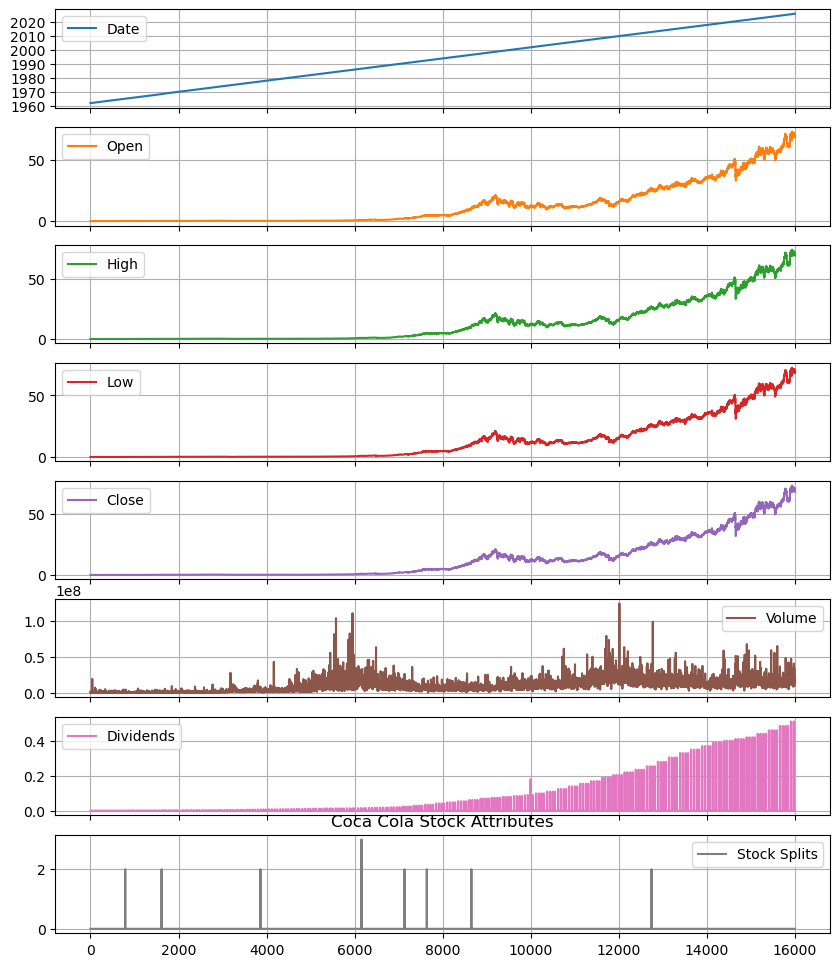

In [20]:
KO_df.plot(subplots=True,figsize=(10,12),grid=True)
plt.title('Coca Cola Stock Attributes')
plt.show()

### Close price trend

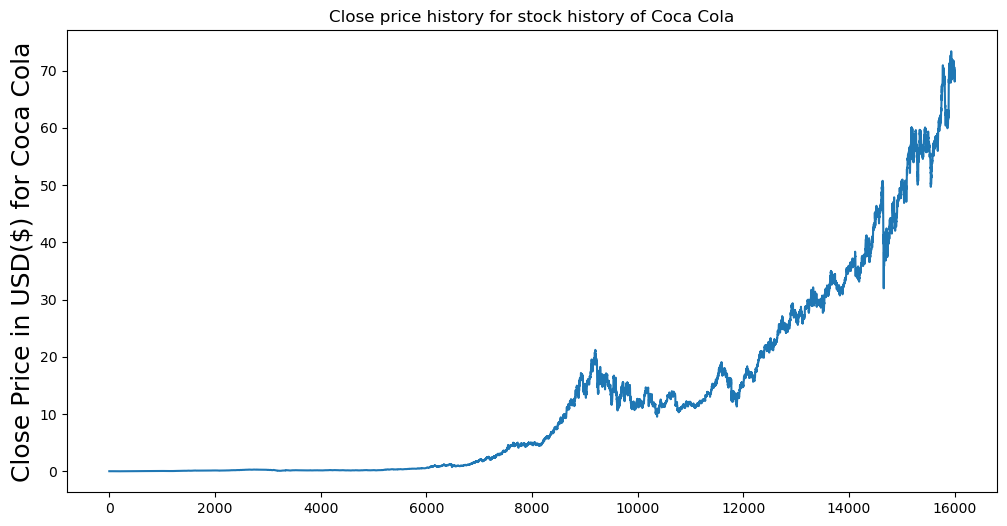

In [21]:
plt.figure(figsize=(12,6))
plt.plot(KO_df['Close'])
plt.title('Close price history for stock history of Coca Cola')
plt.ylabel('Close Price in USD($) for Coca Cola',fontsize=18)
plt.show()

### Open price trend

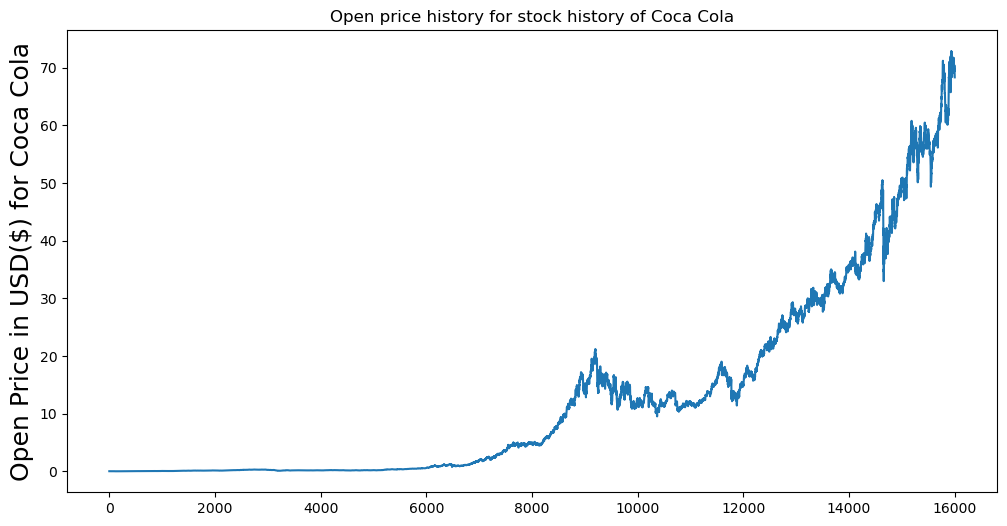

In [22]:
plt.figure(figsize=(12,6))
plt.plot(KO_df['Open'])
plt.title('Open price history for stock history of Coca Cola')
plt.ylabel('Open Price in USD($) for Coca Cola',fontsize=18)
plt.show()

### Distribution of volume through years

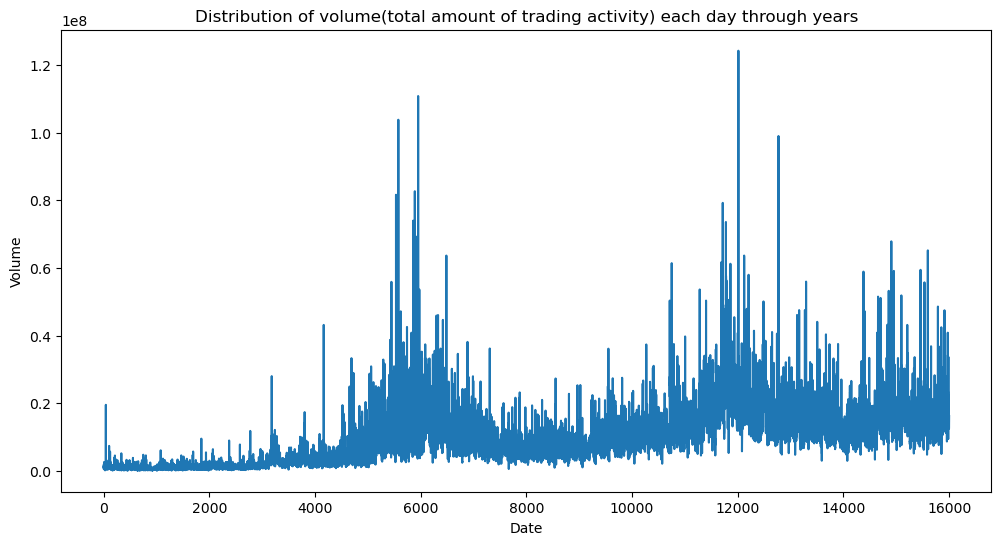

In [23]:
plt.figure(figsize=(12,6))
plt.plot(KO_df['Volume'])
plt.title('Distribution of volume(total amount of trading activity) each day through years')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()


### Distribution of Dividends

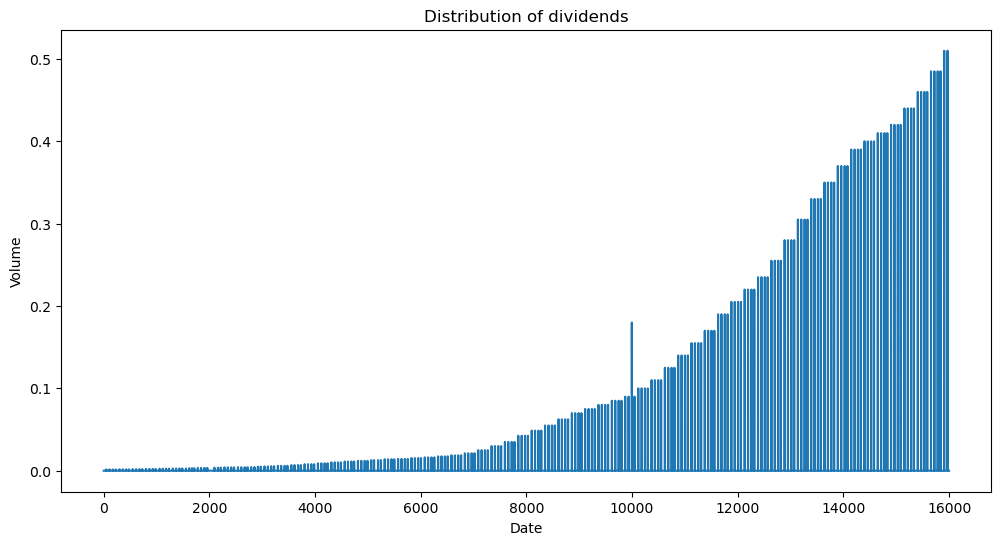

In [24]:
plt.figure(figsize=(12,6))
plt.plot(KO_df['Dividends'])
plt.title('Distribution of dividends')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

In [31]:
#df['Stock Splits'].unique()

array([0, 2, 3], dtype=int64)

In [38]:
#df['Date']=pd.to_datetime(df['Date'],format='mixed',utc=True)


In [39]:
#df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15311 entries, 0 to 15310
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   Date          15311 non-null  datetime64[ns, UTC]
 1   Open          15311 non-null  float64            
 2   High          15311 non-null  float64            
 3   Low           15311 non-null  float64            
 4   Close         15311 non-null  float64            
 5   Volume        15311 non-null  int64              
 6   Dividends     15311 non-null  float64            
 7   Stock Splits  15311 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(2)
memory usage: 957.1 KB


In [25]:
KO_df['Year']=KO_df['Date'].dt.year

In [26]:
KO_df.isnull().sum()

Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
Year            0
dtype: int64

### Stock splits trend

In [27]:
df_grp=KO_df.groupby('Year')['Stock Splits'].count().to_frame().reset_index()
df_grp.columns=['Year','Stock Split Counts']
df_grp

,Year,Stock Split Counts
0,1962,252
1,1963,251
2,1964,253
3,1965,252
4,1966,252
...,...,...
59,2021,252
60,2022,251
61,2023,250
62,2024,252


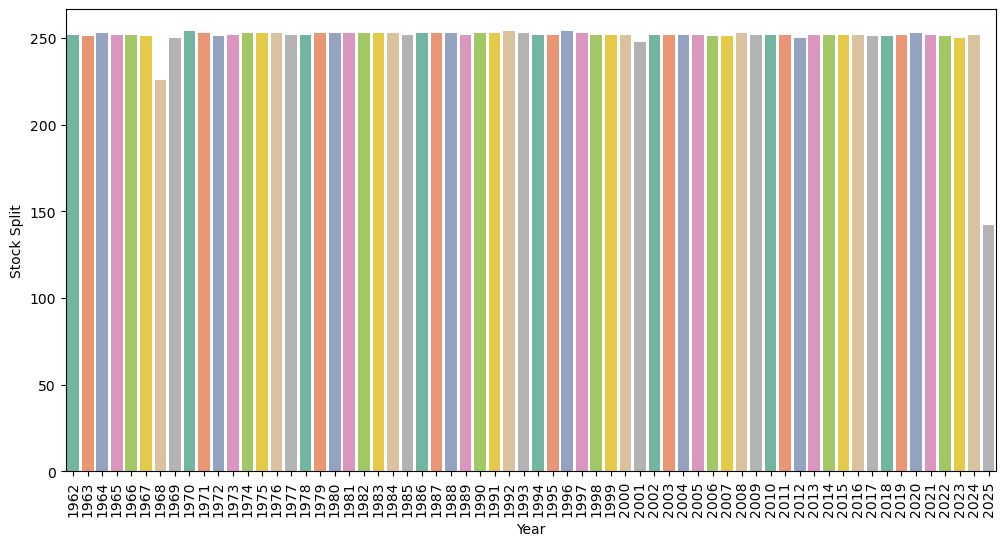

In [28]:
plt.figure(figsize=(12,6))
sns.barplot(y='Stock Split Counts',x='Year',data=df_grp,palette=sns.color_palette('Set2'))
plt.xlabel('Year')
plt.ylabel('Stock Split')
plt.xticks(rotation=90)
plt.show()

The stock splits follow a constant trend. 

## Feature Engineering

In [29]:
def fin_indicators():
    
    df1=pd.DataFrame()
    #Moving averages
    df1['MA_20']=KO_df['Close'].rolling(window=20).mean()
    df1['MA_50']=KO_df['Close'].rolling(window=50).mean()
    df1['MA_252']=KO_df['Close'].rolling(window=252).mean()
    df1['RSI']=TA.RSI(KO_df)
    df1['Average_True_Range']=TA.ATR(KO_df)
    df1['On_Balance_Volume']=TA.OBV(KO_df)
    df1['Volume_Flow_indicator']=TA.VFI(KO_df)
    df1['Volume_Weighted_Average_Price']=TA.VWAP(KO_df)
    df1['Exponential_Moving_Average_50']=TA.EMA(KO_df,50)
    df1['ADX']=TA.ADX(KO_df)
    df1['William%R']=TA.WILLIAMS(KO_df)
    df1['MFI']=TA.MFI(KO_df)
    df1['MOM']=TA.MOM(KO_df)
    df1[['macd','macd_signal']]=TA.MACD(KO_df)
    df1[['Buy_Pressure','Sell_Pressure']]=TA.BASP(KO_df,period=40)
    df1[['Bull_power','Bear_power']]=TA.BASP(KO_df,period=40)



    #Add Daily returns
    df1['Daily_Return']=KO_df['Close'].pct_change()
    df1['Price_Up_or_Down']=np.where(df1['Daily_Return']<0,-1,1)

    #Add volatility
    df1['Volatility']=df1['Daily_Return'].rolling(window=20).std()

    return df1

In [30]:
df1=fin_indicators()

In [31]:
df1.head()

,MA_20,MA_50,MA_252,RSI,Average_True_Range,On_Balance_Volume,Volume_Flow_indicator,Volume_Weighted_Average_Price,Exponential_Moving_Average_50,ADX,...,MOM,macd,macd_signal,Buy_Pressure,Sell_Pressure,Bull_power,Bear_power,Daily_Return,Price_Up_or_Down,Volatility
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.046131,0.045716,NaN,...,NaN,0.000000,0.000000,NaN,1.000000,NaN,1.000000,NaN,1,NaN
1,NaN,NaN,NaN,0.000000,NaN,-1574400.0,NaN,0.045109,0.045197,NaN,...,NaN,-0.000023,-0.000013,2.560000,0.570665,2.560000,0.570665,-0.022279,-1,NaN
2,NaN,NaN,NaN,26.418649,NaN,-729600.0,NaN,0.045100,0.045142,NaN,...,NaN,-0.000019,-0.000015,0.582080,0.425686,0.582080,0.425686,0.007597,1,NaN
3,NaN,NaN,NaN,14.254412,NaN,-2150400.0,NaN,0.044919,0.044844,NaN,...,NaN,-0.000053,-0.000028,0.542438,2.179033,0.542438,2.179033,-0.022615,-1,NaN
4,NaN,NaN,NaN,11.680587,NaN,-4185600.0,NaN,0.044433,0.044568,NaN,...,NaN,-0.000089,-0.000046,3.301226,0.237200,3.301226,0.237200,-0.010282,-1,NaN


In [32]:
df1.fillna(0,inplace=True)

In [33]:
df1.head()

,MA_20,MA_50,MA_252,RSI,Average_True_Range,On_Balance_Volume,Volume_Flow_indicator,Volume_Weighted_Average_Price,Exponential_Moving_Average_50,ADX,...,MOM,macd,macd_signal,Buy_Pressure,Sell_Pressure,Bull_power,Bear_power,Daily_Return,Price_Up_or_Down,Volatility
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.046131,0.045716,0.0,...,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1,0.0
1,0.0,0.0,0.0,0.000000,0.0,-1574400.0,0.0,0.045109,0.045197,0.0,...,0.0,-0.000023,-0.000013,2.560000,0.570665,2.560000,0.570665,-0.022279,-1,0.0
2,0.0,0.0,0.0,26.418649,0.0,-729600.0,0.0,0.045100,0.045142,0.0,...,0.0,-0.000019,-0.000015,0.582080,0.425686,0.582080,0.425686,0.007597,1,0.0
3,0.0,0.0,0.0,14.254412,0.0,-2150400.0,0.0,0.044919,0.044844,0.0,...,0.0,-0.000053,-0.000028,0.542438,2.179033,0.542438,2.179033,-0.022615,-1,0.0
4,0.0,0.0,0.0,11.680587,0.0,-4185600.0,0.0,0.044433,0.044568,0.0,...,0.0,-0.000089,-0.000046,3.301226,0.237200,3.301226,0.237200,-0.010282,-1,0.0


In [34]:
df1.isnull().sum()

MA_20                            0
MA_50                            0
MA_252                           0
RSI                              0
Average_True_Range               0
On_Balance_Volume                0
Volume_Flow_indicator            0
Volume_Weighted_Average_Price    0
Exponential_Moving_Average_50    0
ADX                              0
William%R                        0
MFI                              0
MOM                              0
macd                             0
macd_signal                      0
Buy_Pressure                     0
Sell_Pressure                    0
Bull_power                       0
Bear_power                       0
Daily_Return                     0
Price_Up_or_Down                 0
Volatility                       0
dtype: int64

In [35]:
df=pd.concat([KO_df,df1],axis=1)
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Year,MA_20,...,MOM,macd,macd_signal,Buy_Pressure,Sell_Pressure,Bull_power,Bear_power,Daily_Return,Price_Up_or_Down,Volatility
0,1962-01-02 00:00:00-05:00,0.045716,0.046961,0.045716,0.045716,806400,0.0,0.0,1962,0.0,...,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1,0.0
1,1962-01-03 00:00:00-05:00,0.045038,0.045038,0.044019,0.044698,1574400,0.0,0.0,1962,0.0,...,0.0,-0.000023,-0.000013,2.560000,0.570665,2.560000,0.570665,-0.022279,-1,0.0
2,1962-01-04 00:00:00-05:00,0.044811,0.045377,0.044811,0.045037,844800,0.0,0.0,1962,0.0,...,0.0,-0.000019,-0.000015,0.582080,0.425686,0.582080,0.425686,0.007597,1,0.0
3,1962-01-05 00:00:00-05:00,0.045037,0.045603,0.043906,0.044019,1420800,0.0,0.0,1962,0.0,...,0.0,-0.000053,-0.000028,0.542438,2.179033,0.542438,2.179033,-0.022615,-1,0.0
4,1962-01-08 00:00:00-05:00,0.043679,0.043679,0.042718,0.043566,2035200,0.0,0.0,1962,0.0,...,0.0,-0.000089,-0.000046,3.301226,0.237200,3.301226,0.237200,-0.010282,-1,0.0


In [60]:
df.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Year,MA_20,...,MOM,macd,macd_signal,Buy_Pressure,Sell_Pressure,Bull_power,Bear_power,Daily_Return,Price_Up_or_Down,Volatility
15995,2025-07-23 00:00:00-04:00,69.660004,69.739998,68.599998,69.160004,21030000,0.0,0.0,2025,70.0955,...,-0.320000,-0.255328,-0.208814,1.382132,1.573262,1.382132,1.573262,-0.007178,-1,0.008750
15996,2025-07-24 00:00:00-04:00,69.260002,69.550003,68.989998,69.099998,12511400,0.0,0.0,2025,70.0690,...,-0.669998,-0.294381,-0.225927,0.170111,0.736139,0.170111,0.736139,-0.000868,-1,0.008569
15997,2025-07-25 00:00:00-04:00,69.129997,69.230003,68.750000,69.169998,12574800,0.0,0.0,2025,70.0540,...,-0.700005,-0.316039,-0.243950,0.665053,0.104303,0.665053,0.104303,0.001013,1,0.008561
15998,2025-07-28 00:00:00-04:00,68.739998,68.900002,68.059998,68.089996,13668800,0.0,0.0,2025,69.9420,...,-1.380005,-0.415560,-0.278272,0.054580,1.481654,0.054580,1.481654,-0.015614,-1,0.008687
15999,2025-07-29 00:00:00-04:00,68.339996,69.419998,68.150002,69.379997,16215500,0.0,0.0,2025,69.8735,...,0.019997,-0.385890,-0.299796,2.453780,0.090911,2.453780,0.090911,0.018946,1,0.009705


In [36]:
df.isnull().sum()

Date                             0
Open                             0
High                             0
Low                              0
Close                            0
Volume                           0
Dividends                        0
Stock Splits                     0
Year                             0
MA_20                            0
MA_50                            0
MA_252                           0
RSI                              0
Average_True_Range               0
On_Balance_Volume                0
Volume_Flow_indicator            0
Volume_Weighted_Average_Price    0
Exponential_Moving_Average_50    0
ADX                              0
William%R                        0
MFI                              0
MOM                              0
macd                             0
macd_signal                      0
Buy_Pressure                     0
Sell_Pressure                    0
Bull_power                       0
Bear_power                       0
Daily_Return        

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype                           
---  ------                         --------------  -----                           
 0   Date                           16000 non-null  datetime64[ns, America/New_York]
 1   Open                           16000 non-null  float64                         
 2   High                           16000 non-null  float64                         
 3   Low                            16000 non-null  float64                         
 4   Close                          16000 non-null  float64                         
 5   Volume                         16000 non-null  int64                           
 6   Dividends                      16000 non-null  float64                         
 7   Stock Splits                   16000 non-null  float64                         
 8   Year                           16000

###  Moving averages trend

<Figure size 1500x1200 with 0 Axes>

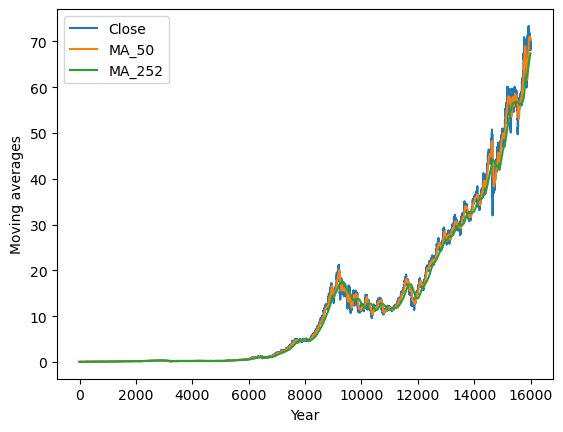

In [38]:
plt.figure(figsize=(15,12))
df[['Close','MA_50','MA_252']].plot()
plt.xlabel('Year')
plt.ylabel('Moving averages')
plt.show()

###  Distribution of percentage change in close price

<Figure size 1500x1200 with 0 Axes>

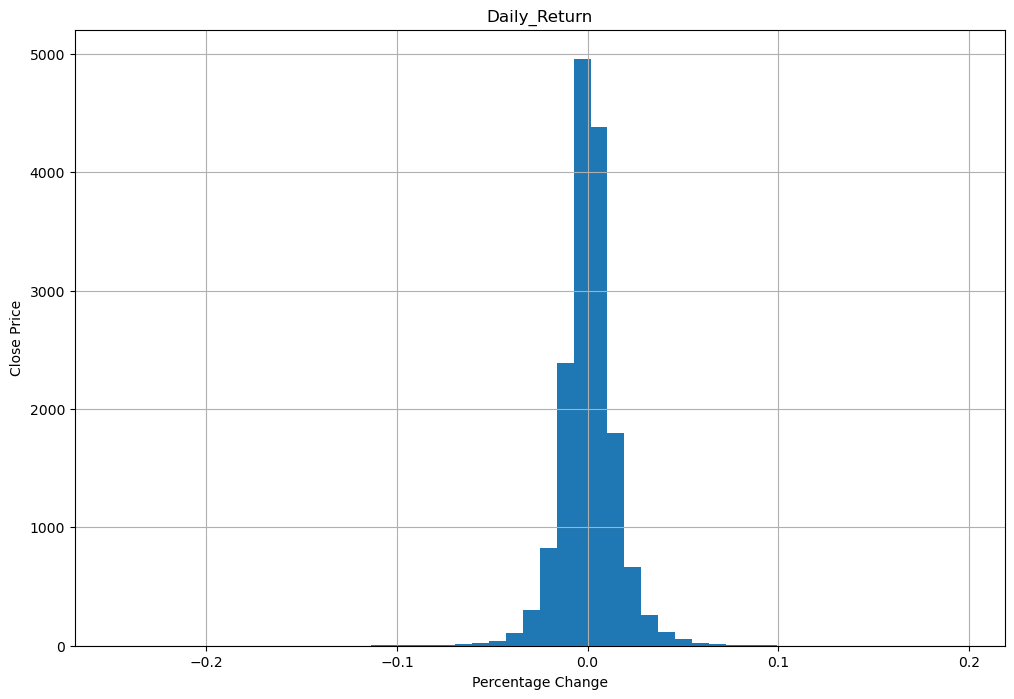

In [44]:
plt.figure(figsize=(15,12))
df[['Daily_Return']].hist(bins=50,sharex=True,figsize=(12,8))
plt.ylabel('Close Price')
plt.xlabel('Percentage Change')
plt.show()

###  Is the stock volatile?

<Axes: >

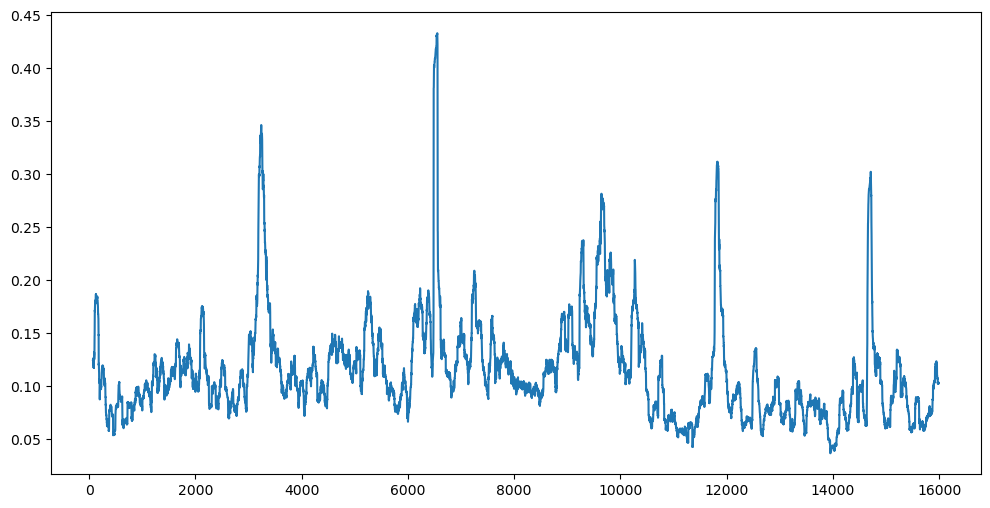

In [33]:
min_period=75
vol=df1['Daily_Return'].rolling(min_period).std()*np.sqrt(min_period)
vol.plot(figsize=(12,6))

The stock is highly volatile.

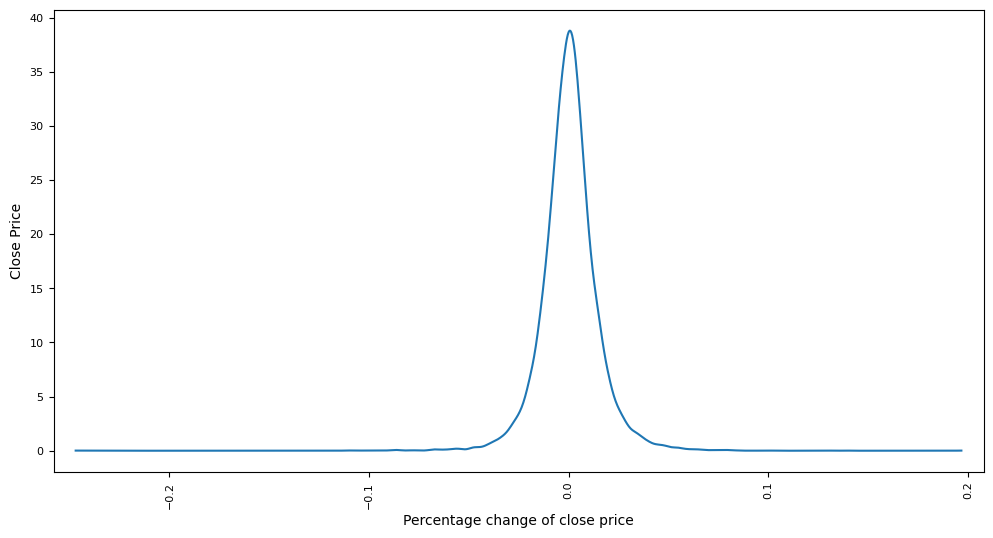

In [34]:
pd.plotting.scatter_matrix(df[['Daily_Return']],diagonal='kde',alpha=0.1,figsize=(12,6))
plt.xlabel('Percentage change of close price')
plt.ylabel('Close Price')
plt.show()

### Correlation analysis

In [45]:
cor=df.corr()
cor

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Year,MA_20,...,MOM,macd,macd_signal,Buy_Pressure,Sell_Pressure,Bull_power,Bear_power,Daily_Return,Price_Up_or_Down,Volatility
Date,1.000000,0.859392,0.859573,0.859247,0.859403,0.620619,0.087254,-0.009208,0.999877,0.859732,...,0.062806,0.130835,0.140705,-0.008630,0.002397,-0.008630,0.002397,-0.006124,-0.020499,-0.149520
Open,0.859392,1.000000,0.999963,0.999957,0.999923,0.439139,0.095266,-0.009974,0.859391,0.999475,...,0.092717,0.195798,0.210022,-0.012091,0.005826,-0.012091,0.005826,-0.009946,-0.014665,-0.213646
High,0.859573,0.999963,1.000000,0.999943,0.999962,0.440358,0.095068,-0.010027,0.859574,0.999486,...,0.093363,0.195070,0.209202,-0.009432,0.005540,-0.009432,0.005540,-0.006983,-0.012250,-0.211839
Low,0.859247,0.999957,0.999943,1.000000,0.999963,0.437500,0.095028,-0.010020,0.859244,0.999389,...,0.095821,0.197636,0.211291,-0.012254,0.002662,-0.012254,0.002662,-0.006585,-0.011837,-0.215812
Close,0.859403,0.999923,0.999962,0.999963,1.000000,0.438829,0.095095,-0.009997,0.859403,0.999407,...,0.096208,0.196856,0.210503,-0.008446,0.001576,-0.008446,0.001576,-0.003822,-0.009572,-0.213794
Volume,0.620619,0.439139,0.440358,0.437500,0.438829,1.000000,0.057512,-0.001063,0.621100,0.442203,...,-0.053488,-0.024558,-0.005660,0.295048,0.288157,0.295048,0.288157,0.006399,-0.006925,0.062306
Dividends,0.087254,0.095266,0.095068,0.095028,0.095095,0.057512,1.000000,-0.001767,0.087006,0.095525,...,0.001115,0.010274,0.015322,0.006243,0.001235,0.006243,0.001235,0.003206,0.000581,-0.022144
Stock Splits,-0.009208,-0.009974,-0.010027,-0.010020,-0.009997,-0.001063,-0.001767,1.000000,-0.009093,-0.010113,...,-0.000079,0.001497,0.001233,0.013746,0.015127,0.013746,0.015127,0.019148,0.015123,-0.004655
Year,0.999877,0.859391,0.859574,0.859244,0.859403,0.621100,0.087006,-0.009093,1.000000,0.859741,...,0.062600,0.130664,0.140632,-0.008515,0.002629,-0.008515,0.002629,-0.006219,-0.020544,-0.150000
MA_20,0.859732,0.999475,0.999486,0.999389,0.999407,0.442203,0.095525,-0.010113,0.859741,1.000000,...,0.064666,0.172371,0.194278,-0.009078,0.007136,-0.009078,0.007136,-0.011212,-0.015395,-0.210456


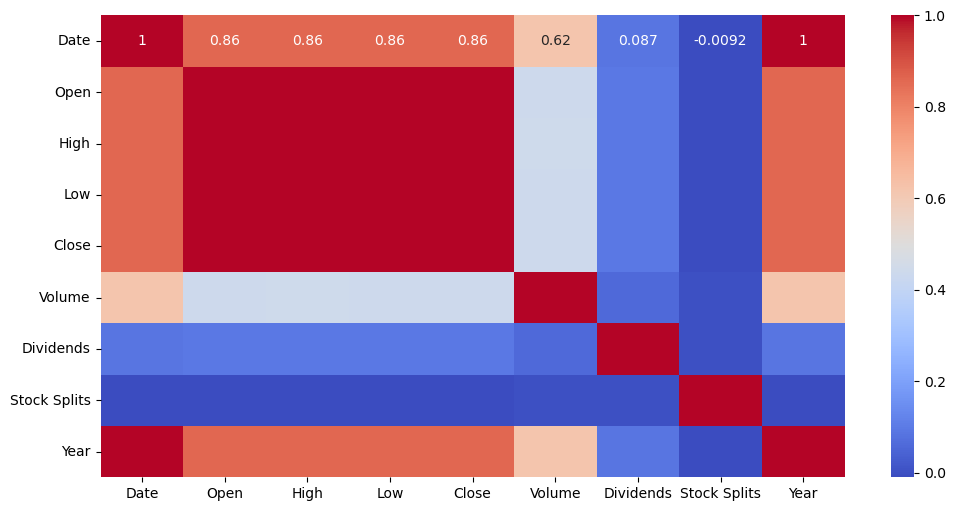

In [46]:
plt.figure(figsize=(12,6))
sns.heatmap(KO_df.corr(),annot=True,cmap='coolwarm')
plt.show()

<Axes: >

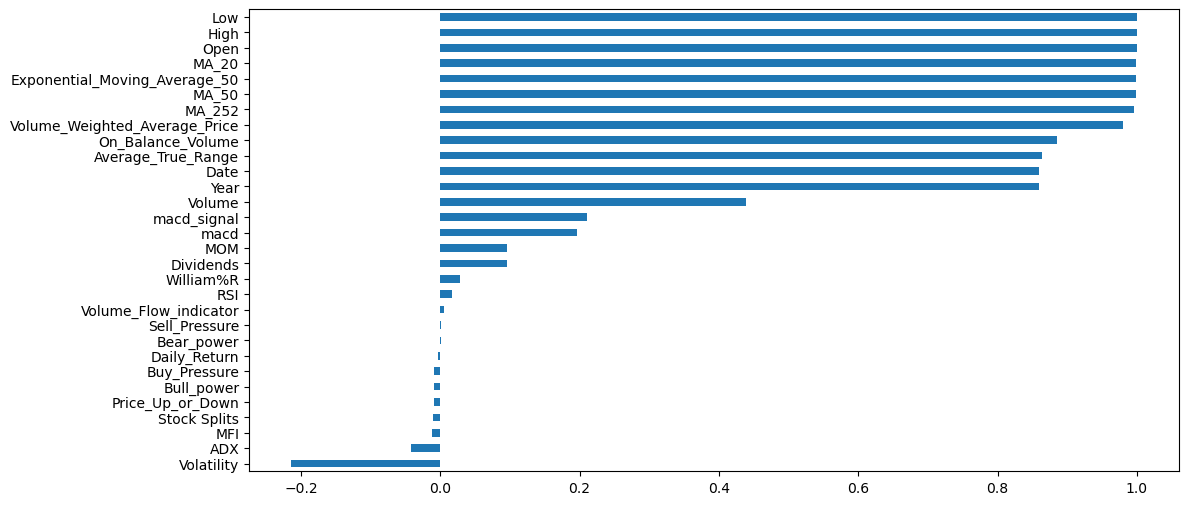

In [47]:
df_corr=df.corr()['Close'].drop('Close')
df_corr=df_corr.sort_values()
df_corr.plot(kind='barh',figsize=(12,6))

## Model Building and Evaluation

In [48]:
X=df[['Open','Low','High','Volume','Dividends','Stock Splits']]
y=df['Close']

In [49]:
x_scale=StandardScaler().fit_transform(X)

In [50]:
X_train,X_test,Y_train,Y_test=train_test_split(x_scale,y,test_size=0.2,random_state=42)

In [51]:
rf=RandomForestRegressor(n_estimators=100,random_state=42)

In [52]:
rf.fit(X_train,Y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [53]:
y_pred=rf.predict(X_test)

In [59]:
print('Mean Squared Error is ',mean_squared_error(Y_test,y_pred))
print('R2 Score is',r2_score(Y_test,y_pred))

Mean Squared Error is  0.01421544694827629
R2 Score is 0.9999480991225451


In [55]:
Close_Price_Pred=pd.DataFrame()
Close_Price_Pred['Close Price']=y_pred

In [56]:
Close_Price_Pred.to_csv("D://Unified mentor internship projects//Coca_Cola_Stock_Price.csv",index=False,header=True)

## Deploy the system

In [46]:
st.title('Coca Cola Stock Live and Updated')
st.subheader('DataFrame')
st.dataframe(KO_df)

st.title('Line Chart')
st.line_chart(KO_df[['Close','MA_20','MA_50']])



2025-07-11 15:33:12.495 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-11 15:33:14.045 
  command:

    streamlit run C:\Users\Krishna Kumar\anaconda3\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-07-11 15:33:14.046 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-11 15:33:14.047 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-11 15:33:14.047 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-11 15:33:14.083 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-11 15:33:14.084 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()